## Import necessary libararies

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from tensorflow.keras.utils import plot_model
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

## Read inputs

In [ ]:
image_path = '/Users/ankitadeshmukh/Desktop/SJSU/Academic/Spring23/ISE244/Project/Code/Flicker8k'
data = pd.read_csv("/Users/ankitadeshmukh/Desktop/SJSU/Academic/Spring23/ISE244/Project/Code/Flicker8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
# This function reads an image from a specified file path and resizes it to a specified size
def readImage(path,img_size=224):
    # load the image from the file path and convert it to an RGB color format
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    # convert the image to a numpy array
    img = img_to_array(img)
    # scale the pixel values to be between 0 and 1
    img = img/255.
    
    # return the processed image
    return img


# This function displays a grid of images and their captions
def display_images(temp_df):
    # Reset the index of the DataFrame to ensure that it starts from 0
    temp_df = temp_df.reset_index(drop=True)
    # Set the size of the plot figure to be 20x20 inches
    plt.figure(figsize = (20 , 20))
    # Initialize a counter for the image subplot positions
    n = 0
    # Loop through the first 15 rows of the DataFrame
    for i in range(15):
        # Increment the subplot position counter
        n+=1
        # Create a subplot with 5 rows, 5 columns, and the current position
        plt.subplot(5 , 5, n)
        # Adjust the spacing between subplots
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        # Load the image corresponding to the current row using the readImage function
        image = readImage(f"/Users/ankitadeshmukh/Desktop/SJSU/Academic/Spring23/ISE244/Project/Code/Flicker8k/{temp_df.image[i]}")
        # Show the image in the subplot
        plt.imshow(image)
        # Set the title of the subplot to be the caption for the current row, wrapped to 20 characters per line
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        # Remove the axis ticks and labels for the subplot
        plt.axis("off")


# **Visualization**
Images and their corresponding captions

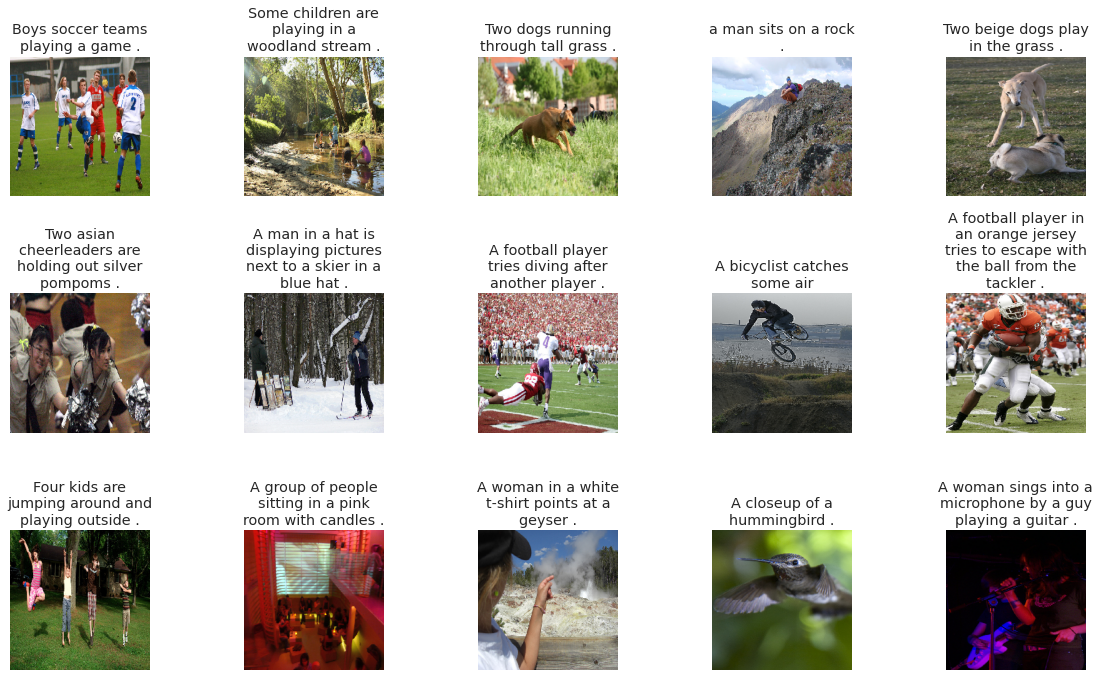

In [ ]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**

- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

In [ ]:
# Create a tokenizer object
tokenizer = Tokenizer()
# Fit the tokenizer on the captions data to build a vocabulary
tokenizer.fit_on_texts(captions)
# Get the size of the vocabulary by adding 1 to the length of the word index
vocab_size = len(tokenizer.word_index) + 1
# Get the maximum length of a caption by finding the length of the longest caption in the captions list
max_length = max(len(caption.split()) for caption in captions)

# Get a list of unique image names from the 'image' column of the DataFrame
images = data['image'].unique().tolist()
# Get the number of unique images
nimages = len(images)

# Split the images into training and validation sets using an 85/15 split
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

# Create training and testing DataFrames by selecting the rows of the original DataFrame that correspond to the training and validation images, respectively
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

# Reset the index of the training and testing DataFrames to ensure that the indices start from 0
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

# Convert the second caption in the captions list to a sequence of integers using the tokenizer
tokenizer.texts_to_sequences([captions[1]])[0]


[1, 18, 315, 63, 195, 116, 2]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- I also tried using VGG but in case of this dataset, DenseNet 201 performed better
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920


In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82534400/82524592 [==============================] - 0s 0us/step


100%|██████████| 8091/8091 [11:33<00:00, 11.67it/s]


# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [ ]:
# This is a custom data generator class for training a neural network model for image captioning.

class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
        """
        Initializes the instance of the class with the following parameters:
        df: a Pandas DataFrame containing the data (image filenames and corresponding captions)
        X_col: the name of the column containing the image filenames in df
        y_col: the name of the column containing the captions in df
        batch_size: the number of samples per batch
        directory: the directory containing the images
        tokenizer: a Keras Tokenizer object for tokenizing the captions
        vocab_size: the vocabulary size of the tokenized captions
        max_length: the maximum length of the tokenized captions
        features: a dictionary containing precomputed image features
        shuffle: whether to shuffle the data before each epoch
        """
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        """
        Shuffles the data if shuffle parameter is set to True.
        """
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        """
        Generates one batch of data.
        """
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self, batch):
        """
        Takes a batch of data and preprocesses it to generate inputs X1 and X2, and target y for the model.
        """
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            # Extract image features from the features dictionary
            feature = self.features[image][0]
            
            # Extract the captions corresponding to the images in the batch from the df DataFrame
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                # Tokenize the captions using the tokenizer object, and generate sequences of input-output pairs
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                # Generate input-output pairs for each sequence
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

In [ ]:
# Define input layers for image and caption data
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

# Define a dense layer to transform the image input into a 256-dimensional vector and reshape it
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# Define an embedding layer for the caption input with a 256-dimensional output
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Concatenate the image and caption features along the time dimension (axis=1)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

# Define an LSTM layer to process the merged features
sentence_features = LSTM(256)(merged)

# Apply dropout regularization to the LSTM output
x = Dropout(0.5)(sentence_features)

# Add the original image features to the LSTM output
x = add([x, img_features])

# Define a dense layer with 128 units and ReLU activation function
x = Dense(128, activation='relu')(x)

# Apply dropout regularization to the dense layer output
x = Dropout(0.5)(x)

# Define a dense layer with softmax activation function to output the predicted probabilities of the next word in the sequence
output = Dense(vocab_size, activation='softmax')(x)

# Define the model with input layers and output layer
caption_model = Model(inputs=[input1, input2], outputs=output)

# Compile the model with categorical cross-entropy loss function and Adam optimizer
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')


## **Model Modification**
- A slight change has been made in the original model architecture to improve the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed in "Show and Tell: A Neural Image Caption Generator" (https://arxiv.org/pdf/1411.4555.pdf)

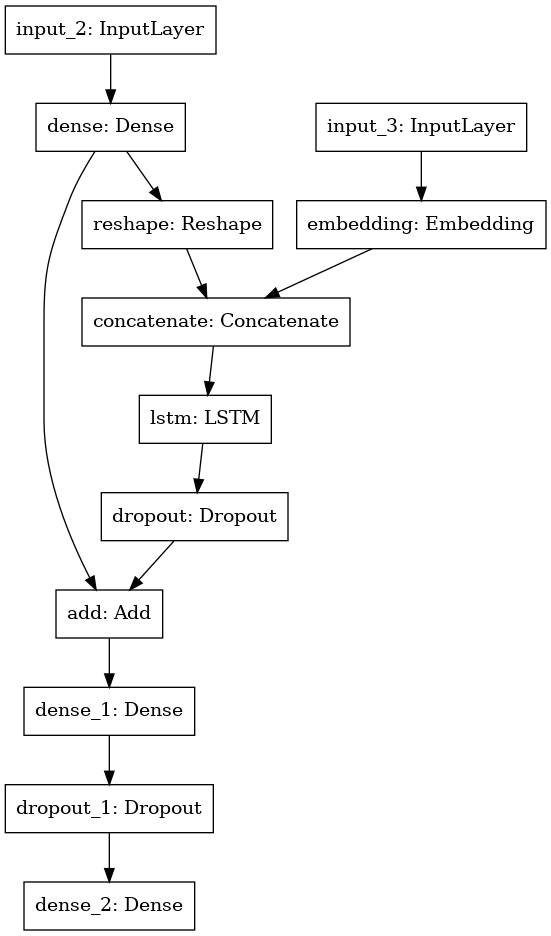

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1920)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          491776      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 256)       0           dense[0][0]                      
____________________________________________________________________________________________

In [ ]:
# Creating a generator for training data
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# Creating a generator for validation data
validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
# Define the name of the saved model file
model_name = "model.h5"

# Define a callback to save only the best model during training based on the validation loss
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# Define a callback to stop training if there is no improvement in validation loss for a certain number of epochs
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)

# Define a callback to reduce the learning rate if validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - 240s 441ms/step - loss: 5.1181 - val_loss: 4.2500

Epoch 00001: val_loss improved from inf to 4.24999, saving model to model.h5
Epoch 2/50
537/537 [==============================] - 50s 93ms/step - loss: 4.1758 - val_loss: 3.9103

Epoch 00002: val_loss improved from 4.24999 to 3.91026, saving model to model.h5
Epoch 3/50
537/537 [==============================] - 50s 94ms/step - loss: 3.9126 - val_loss: 3.7718

Epoch 00003: val_loss improved from 3.91026 to 3.77184, saving model to model.h5
Epoch 4/50
537/537 [==============================] - 51s 94ms/step - loss: 3.7508 - val_loss: 3.6881

Epoch 00004: val_loss improved from 3.77184 to 3.68810, saving model to model.h5
Epoch 5/50
537/537 [==============================] - 51s 95ms/step - loss: 3.6284 - val_loss: 3.6542

Epoch 00005: val_loss improved from 3.68810 to 3.65423, saving model to model.h5
Epoch 6/50
537/537 [==============================] - 49s 92ms/step - loss: 3.5359

# **Inference**
- Learning Curve (Loss Curve)
- BLEU Score 

Text(0.5, 1.0, 'Neural Network Learning Curve')

Text(0.5, 0, 'Number of training examples')

Text(0, 0.5, 'Score')

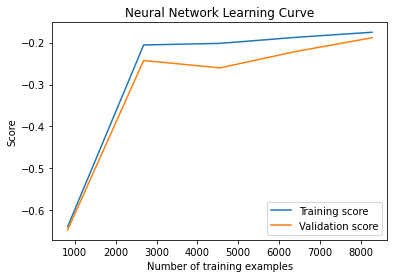

In [ ]:
# Plot the learning curves for the artificial neural network model
train_sizes, train_scores, test_scores = learning_curve(ann_model, X_train_scaled, y_train_scaled, cv=5)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes*5, train_mean, label='Training score')
plt.plot(train_sizes*5, test_mean, label='Validation score')
plt.title('Neural Network Learning Curve')
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.legend()
plt.show()

## **Learning Curve**
- Since the training and testing scores both increase with more training examples and converge to a high score, the model has a good fit to the data, and more data is unlikely to improve the model's performance further. This indicates a good balance between bias and variance, and the model has an appropriate level of complexity. There is no underfitting or overfitting.

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [ ]:
def idx_to_word(integer, tokenizer):
    """
    Convert an integer index to its corresponding word token in a tokenizer.

    Args:
        integer (int): Integer index to be converted to a word.
        tokenizer (Tokenizer): Tokenizer object with the word to index mapping.

    Returns:
        word (str): Corresponding word token for the input integer index.
    """
    # Iterate through the word index mapping in the tokenizer to find the word corresponding to the integer index.
    for word, index in tokenizer.word_index.items():
        if index == integer:
            # Return the word if it has the same index as the input integer.
            return word
    # If the integer does not correspond to any word in the tokenizer, return None.
    return None


In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    """
    Generate a caption for the given image using the trained model and tokenizer.

    Args:
        model (keras Model): Trained model for generating captions.
        image (str): Filename of the image to generate the caption for.
        tokenizer (keras Tokenizer): Tokenizer used for training the model.
        max_length (int): Maximum length of the caption.
        features (dict): Dictionary containing extracted features of images.

    Returns:
        str: Generated caption for the given image.
    """
    # Get the extracted features of the image from the dictionary
    feature = features[image]
    
    # Initialize the caption with the start sequence token
    in_text = "startseq"
    
    # Loop over each word in the caption
    for i in range(max_length):
        # Convert the caption into a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to have the same length as the maximum length
        sequence = pad_sequences([sequence], max_length)

        # Generate predictions for the current sequence and image features
        y_pred = model.predict([feature,sequence])
        # Select the word with the highest probability as the predicted word
        y_pred = np.argmax(y_pred)
        
        # Convert the predicted integer back to its corresponding word
        word = idx_to_word(y_pred, tokenizer)
        
        # If the predicted word is not found, break the loop
        if word is None:
            break
            
        # Append the predicted word to the caption
        in_text+= " " + word
        
        # If the end sequence token is predicted, break the loop
        if word == 'endseq':
            break
            
    # Return the generated caption
    return in_text

## **Taking 15 Random Samples for Caption Prediction**

In [ ]:
samples = test.sample(1000)
samples.reset_index(drop=True,inplace=True)

In [ ]:
predicted_captions = []
actual_captions = []

for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption
    for i in range(5):
        predicted_captions.append(caption)

    # locate rows where 'image' column contains the search string
    mask = data['image'].str.contains(record['image'])
    # retrieve the corresponding caption values
    captions = data.loc[mask, 'caption'].tolist()

    # if there are exactly 5 matches, store them in separate variables
    if len(captions) == 5:
        for cap in captions:
            actual_captions.append(cap)
    else:
        print("Error: search string not found exactly 5 times.")
        

In [ ]:
for i in range(len(predicted_captions)):
    corpus_score = corpus_bleu(actual_captions, predicted_captions)
print('Overall Corpus BLEU Score:', corpus_score*100)

Overall Corpus BLEU Score:  71.1315618969


In [1]:
# Calculate BLEU scores for n-gram values 1 to 4
avg_bleu_scores = []
ngram_scores = []

for i in range(1,5): 
  for j in range(len(predicted_captions)):
      ngram_score = sentence_bleu(actual_captions[j], predicted_captions[j], weights=(1.0/i, 0, 0, 0))
      ngram_scores.append(ngram_score)
      
  avg_ngram_score = sum(ngram_scores) / len(ngram_scores)
  avg_bleu_scores.append(avg_ngram_score)
  print(f"BLEU-{i} Score: {avg_ngram_score*100}")

BLEU-1 Score:  28.1053718711
BLEU-2 Score:  52.8413589168
BLEU-3 Score:  65.3136283348
BLEU-4 Score:  72.6315618969


## Results

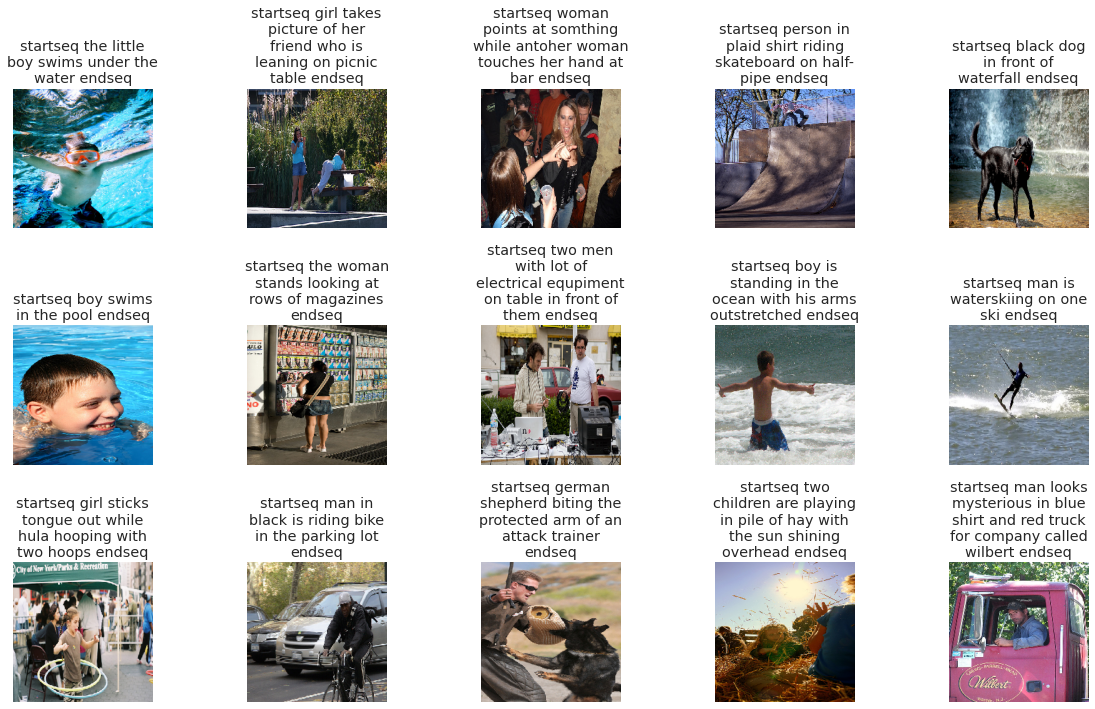

In [ ]:
display_images(samples)

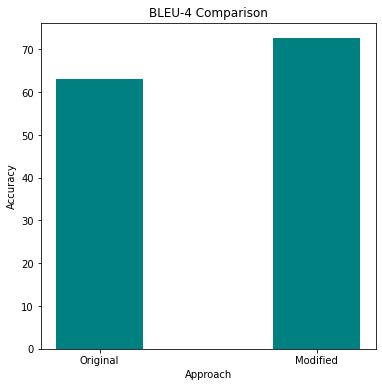

In [ ]:
import matplotlib.pyplot as plt

bleu4_list = [63, 72.6315618969]
bleu4_names = ["Original", "Modified"]


fig = plt.figure(figsize = (6, 6))
# creating the bar plot
plt.bar(bleu4_names, bleu4_list, color ='teal',
        width = 0.4)
plt.xlabel("Approach")
plt.ylabel("Accuracy")
plt.title("BLEU-4 Comparison")
plt.show()

## Results
- The model gave BLEU-4 score of 72.63 which is a good improvement over the Show and Tell paper which claimed the BLEU-4 score of 63 on Flicker8k dataset
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation